## Generative Adversarial Network (GAN) with Python and Tensorflow

### Import dependencies

In [9]:
# dataset and visualization components
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# modeling components
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### Load and visualize data

In [10]:
# Load the mnist dataset from tensorflow_datasets
ds = tfds.load('mnist', split='train')

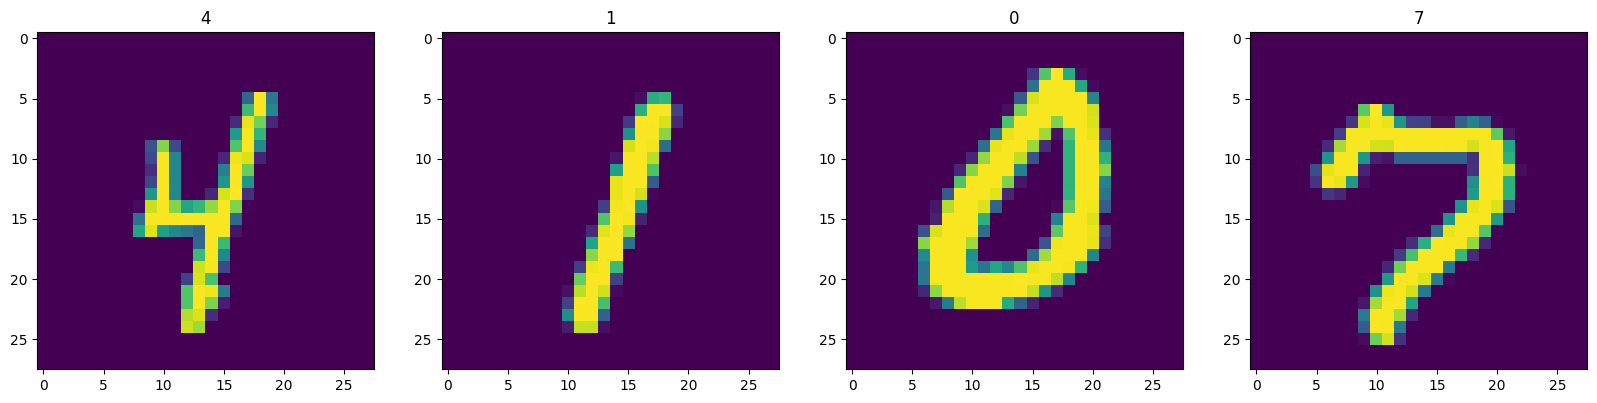

In [11]:
# Convert the data to a numpy iterator
data_iterator = ds.as_numpy_iterator()

# Visualize the data
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    # Grab an image and label
    sample = data_iterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

### Pre-process data

In [12]:
# Scale all the images
def scale_images(data): 
    image = data['image']
    return image / 255

In [13]:
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [14]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

### Build the generator

In [15]:
def build_generator():
    model = Sequential()                       # define our model
    model.add(Dense(7*7*128, input_dim=128))   # add Dense layer with random noise as input
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation
    model.add(Reshape((7,7,128)))              # reshape to 17*17*128

    # Upsampling block - 1
    model.add(UpSampling2D())                  # layer used to increase the spatial resolution of the input
    model.add(Conv2D(128, 5, padding='same'))  # convolutional nn layer with 128 units, kernel size 5x5 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Upsampling block - 2
    model.add(UpSampling2D())                  # layer used to increase the spatial resolution of the input
    model.add(Conv2D(128, 5, padding='same'))  # convolutional nn layer with 128 units, kernel size 5x5 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Downsampling block - 1
    model.add(Conv2D(128, 4, padding='same'))  # convolutional nn layer with 128 units, kernel size 4x4 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Downsampling block - 2
    model.add(Conv2D(128, 4, padding='same'))  # convolutional nn layer with 128 units, kernel size 4x4 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # convolutional nn layer to change to 1 channel,kernel size 4x4, same padding and a sigmoid activation this time
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    # return the model
    return model

In [16]:
# generator summary
generator = build_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                      

### Test the generator

1/1 [==============================] - 0s 28ms/step


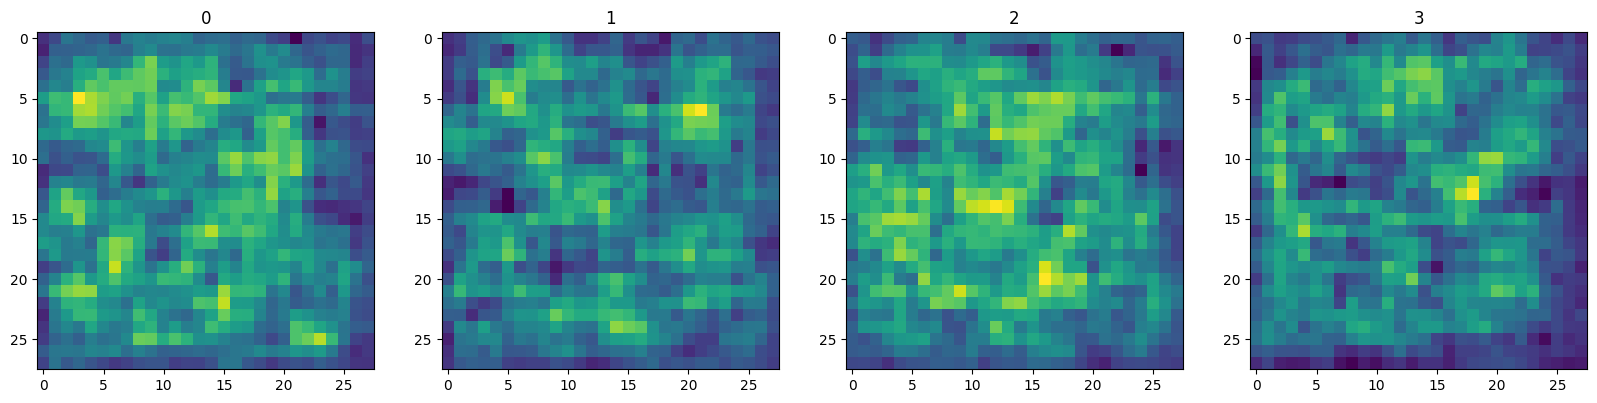

In [18]:
# Generate 4 new images
img = generator.predict(np.random.randn(4,128,1))

# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop 4 times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)